# G9: Probability and Statistics for Artificial Intelligence (AAI-500-IN2)

## Introduction
Our project looks at a UK-based online retail for gift sales dataset.

Conduct a descriptive analysis of the Online Retail dataset as part of your data analysis project. We have a transactional dataset with 541,909 instances and 6 key features: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Load the dataset
from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Group 9 Project/Data/Online Retail.csv', encoding='ISO-8859-1')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning and Preparation

### Preview the data

First 5 rows of the dataset:

In [2]:
# Display first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Display the data types:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Check for missing values


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


<Figure size 800x600 with 0 Axes>

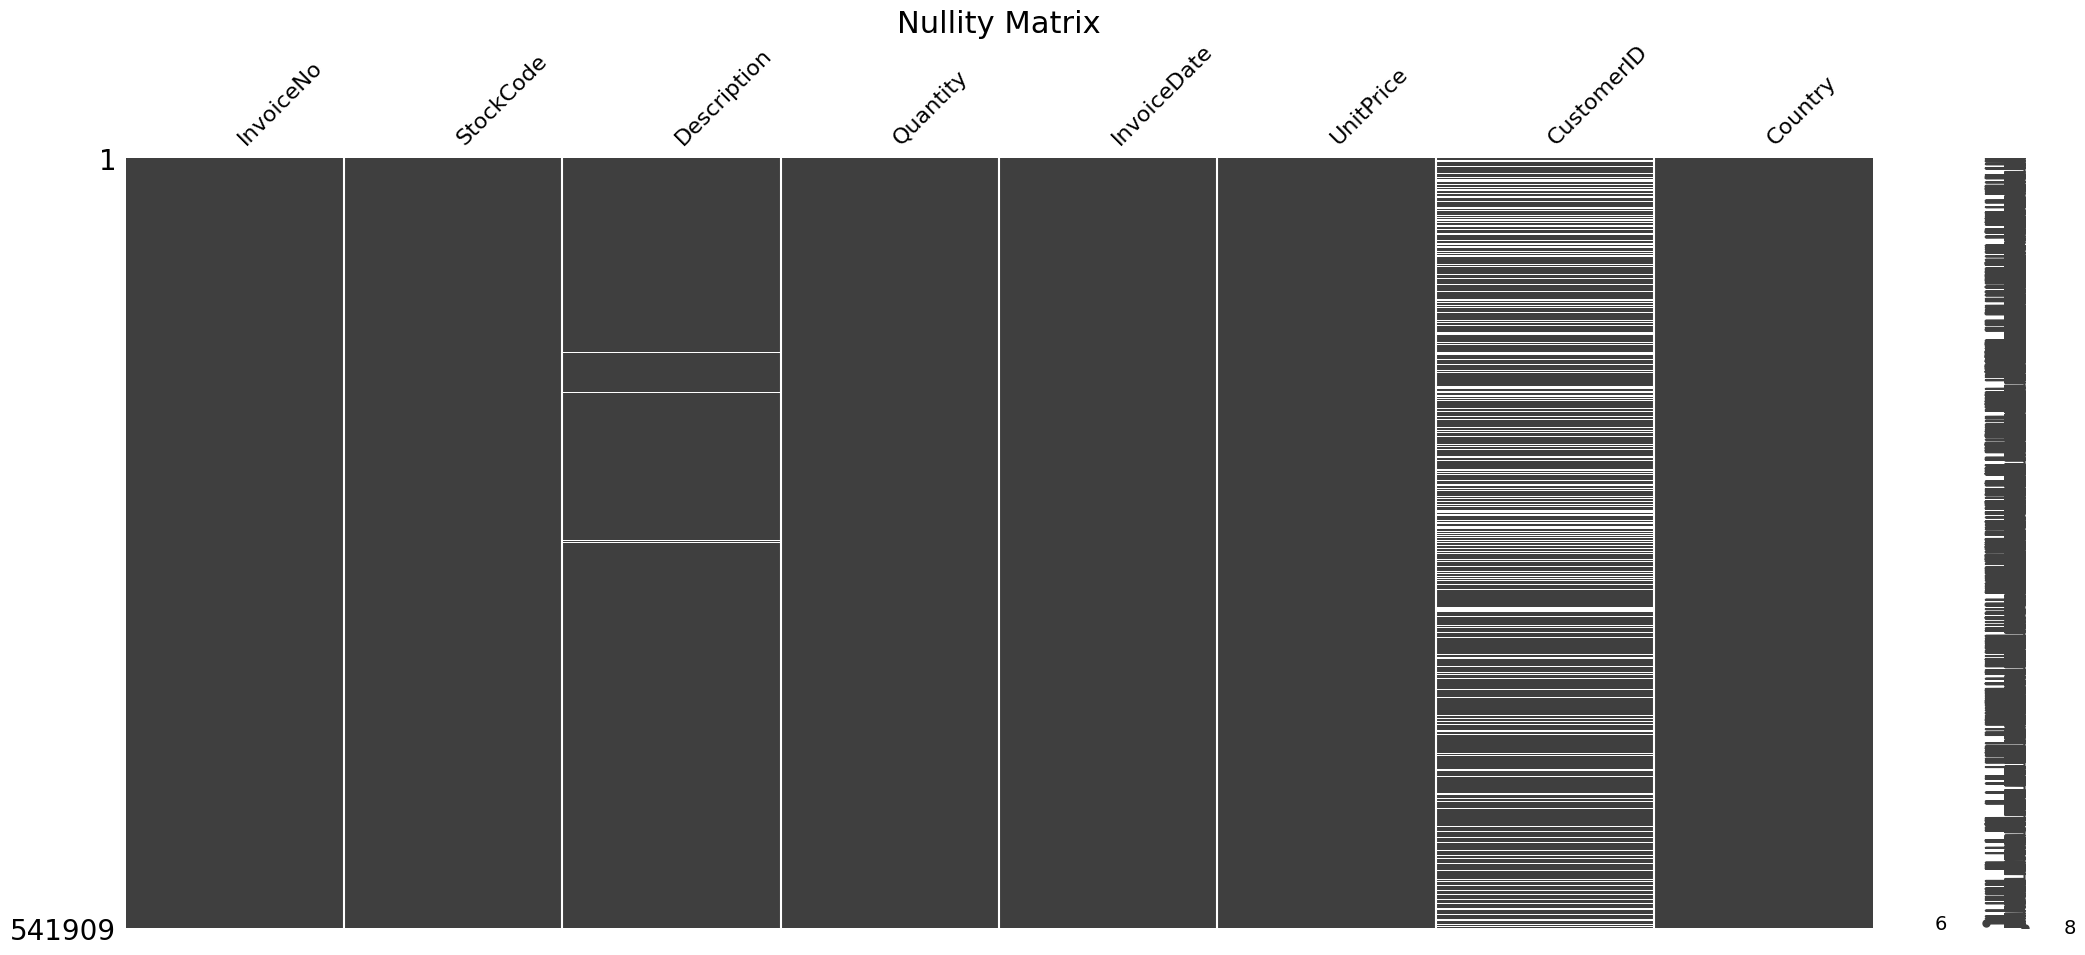

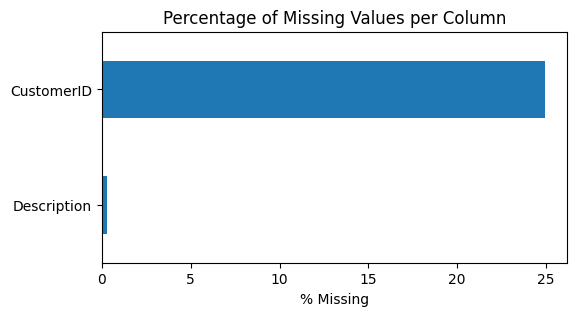

In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Show nullity across all columns
plt.figure(figsize=(8, 6))
msno.matrix(df)
plt.title('Nullity Matrix', fontsize=22)
plt.show()

missing_percent = df.isnull().mean() * 100

plt.figure(figsize=(6, 3))
missing_percent[missing_percent > 0].sort_values().plot.barh()
plt.title('Percentage of Missing Values per Column')
plt.xlabel('% Missing')
plt.show()

We have seen the first 5 rows, data types, and missing value counts. The dataset has no missing values as per the documentation, but we verified this anyways. The `InvoiceDate` may need parsing as a datetime object, and `CustomerID` might be float but should be treated as categorical.

## Data Cleaning and Preparation

Even though the dataset has no missing values, we need to:

- Convert `InvoiceDate` to datetime.
- Check for cancellations (transactions where `InvoiceNo` starts with 'C').
- Ensure `CustomerID` is treated as a string (categorical).
- Look for outliers or invalid data (e.g., negative `Quantity` or `UnitPrice`).
- Add a `TotalPrice` to allow revenue analysis

#### Update Data Types

In [5]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert CustomerID to string (categorical)
df['CustomerID'] = df['CustomerID'].astype(str)

# Identify cancellations
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C')

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#### Treatment of Outliers

The `Quantity` field includes both positive and negative values (negative likely due to cancellations, as `InvoiceNo` starting with 'C' indicates)

- Negative quantities (cancellations) may affect the shape of the distribution.
- The data may have extreme positive outliers (e.g., bulk orders).
- The underlying distribution might be log-normal rather than normal, which is common for quantities in retail data.

To address outliers, we can follow several approaches:

- **Option 1: Filter Out Negative Quantities (Cancellations)**  
  Since negative quantities likely represent cancellations, you can exclude them to focus on actual sales.
  ```python
  # Filter out cancellations and negative quantities
  df = df[(df['IsCancelled'] == False) & (df['Quantity'] > 0)]
  ```
- **Option 2: Winsorize or Cap Outliers**  
  Winsorizing replaces extreme values with a specified percentile threshold (e.g., 1st and 99th percentiles), reducing the impact of outliers without removing data.
  ```python
  # Winsorize Quantity at 1st and 99th percentiles
  df['QuantityWinsorized'] = mstats.winsorize(df['Quantity'], limits=[0.01, 0.01])
  ```
- **Option 3: Remove Extreme Outliers Using IQR**  
  Use the Interquartile Range (IQR) method to identify and remove outliers, keeping data within 1.5 times the IQR from the quartiles.
  ```python
  # Calculate IQR
  Q1 = df['Quantity'].quantile(0.25)
  Q3 = df['Quantity'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df = df[(df['Quantity'] >= lower_bound) & (df['Quantity'] <= upper_bound)]
  ```

### Negative Values

Negative quantities might indicate returns or cancellations, which we'll analyze separately.

If negative `UnitPrice` exists, it could be an error unless it represents adjustments.

We'll keep cancellations for now to analyze their impact.

In [6]:
# Check for negative quantities or prices
print("\nNegative Quantities:", (df['Quantity'] < 0).sum())
print("Negative Unit Prices:", (df['UnitPrice'] < 0).sum())

# Basic data cleaning: Remove invalid entries if needed
#df = df[df['Quantity'] >= 0] #Drop negative Quantity if they exist
df = df[df['UnitPrice'] >= 0] #Drop negative UnitPrice if they exist

# Filter out cancellations
df_cancellations = df[(df['IsCancelled'] == True)]
df = df[(df['IsCancelled'] == False)]


Negative Quantities: 10624
Negative Unit Prices: 2


## Exploratory Data Analysis (EDA)

For our exploratory data analysis, we will initially just try to understand the data we have. It might be important to formulate a number of research questions that will help structure our EDA i.e. give us something to look for in the data.

### Research Questions

When we look at the variables: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, and the derived TotalPrice and IsCancelled, we can start thinking of inferential research questions that we can ask on this dataset.

Inferential analysis aims to draw conclusions about the population beyond descriptive summaries, often using statistical tests or models to test hypotheses or predict outcomes.

Goals for our inferential analysis could include testing hypotheses, identifying relationships, or predicting outcomes to inform business decisions (e.g. customer behavior, sales trends).

1. Understand Customer Behavior and Segmentation: *Do customers from different countries have significantly different purchasing patterns (e.g. average order value or frequency)?*   
  Understanding country-based differences can inform targeted marketing strategies. We could use use ANOVA to test if mean TotalPrice differs across countries.

2. Understanding Cancellation Patterns: *Are cancellations (IsCancelled) more likely for specific product types or customer segments?*  
  Identifying cancellation drivers can reduce revenue loss. We can use a regression model to predict IsCancelled using features like StockCode, Quantity, UnitPrice, and Country. Chi-square tests can assess associations between cancellations and categorical variables.

3. Identify Trends in Sales Over Time: *Is there a significant seasonal effect on sales volume or transaction frequency?*  
  Detecting seasonality can optimize inventory and marketing campaigns. This could be done through time-series analysis to identify seasonality.

4. Determine Product Popularity and Revenue Contribution: *Do certain products (StockCode) contribute disproportionately to total revenue, and are these differences statistically significant?*  
  Identifying top-performing products aids inventory management. Perform analysis to identify top revenue-generating products, followed by t-tests or ANOVA to compare TotalPrice across product groups.

5. Insgihts Into Customer Retention: *Do first-time customers have a significantly lower likelihood of repeat purchases compared to returning customers?*  
  Retention insights can guide customer loyalty programs. Define first-time vs. returning customers based on CustomerID and InvoiceDate. Develop models (e.g. regression, survival analysis, etc) to predict repeat purchase likelihood.

### Descriptive Statistics

Given that this is a dataset for an online retailer store, we may expect to find:  

* `Quantity` and `UnitPrice` may have skewed distributions (e.g., large orders or high-priced items).
* `Country` will likely show the UK as dominant (since it's UK-based retail).
* Cancellations (`IsCancelled`) will help quantify returns.
* The date range confirms transactions from Dec 2010 to Dec 2011.

In [7]:
# Top 5 countries by transaction count
print("\nTop 5 Countries by Transaction Count:")
df['Country'].value_counts().head()



Top 5 Countries by Transaction Count:


,count
Country,
United Kingdom,487620
Germany,9042
France,8408
EIRE,7894
Spain,2485


In [8]:
# Transaction date range
print("\nDate Range:")
print(f"From: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")


Date Range:
From: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


#### Descriptive Statistics for Numerical Features:

In [9]:
numeric_cols = ['Quantity', 'UnitPrice']

# Numerical features summary
stats = df[numeric_cols].describe().T
stats['IQR'] = stats['75%'] - stats['25%']
stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].T

,Quantity,UnitPrice
count,532619.000000,532619.000000
mean,10.240006,3.889174
std,159.593850,35.831786
min,-9600.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000
IQR,9.000000,2.880000


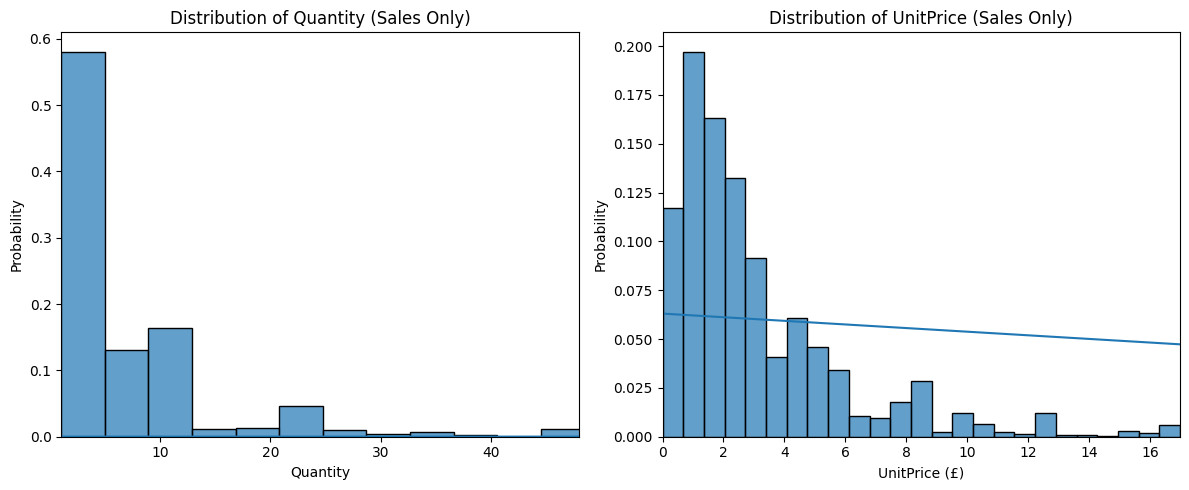

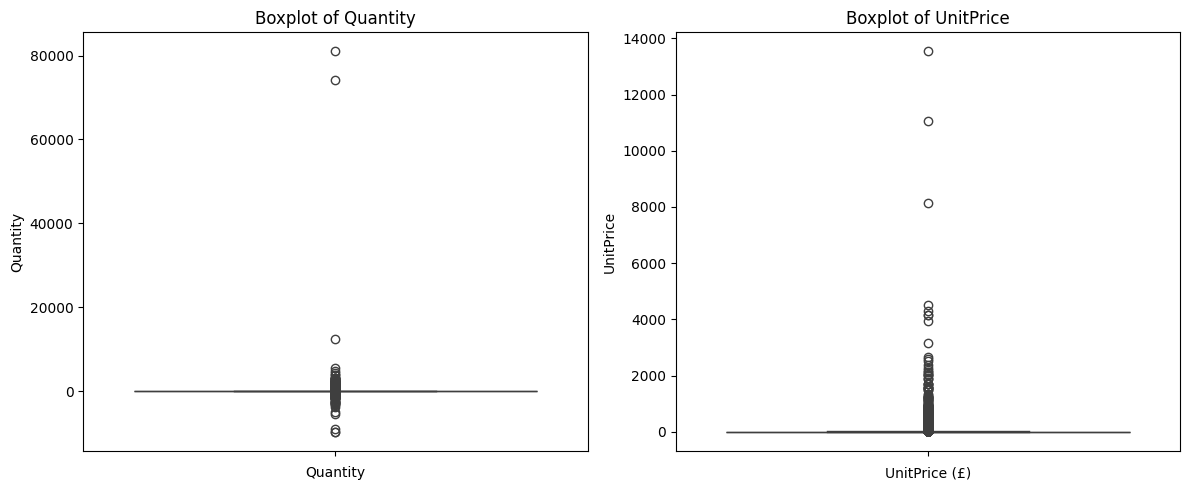

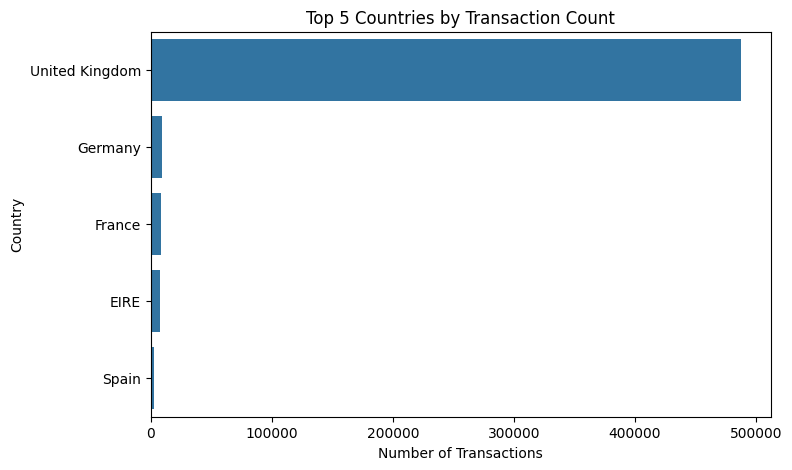

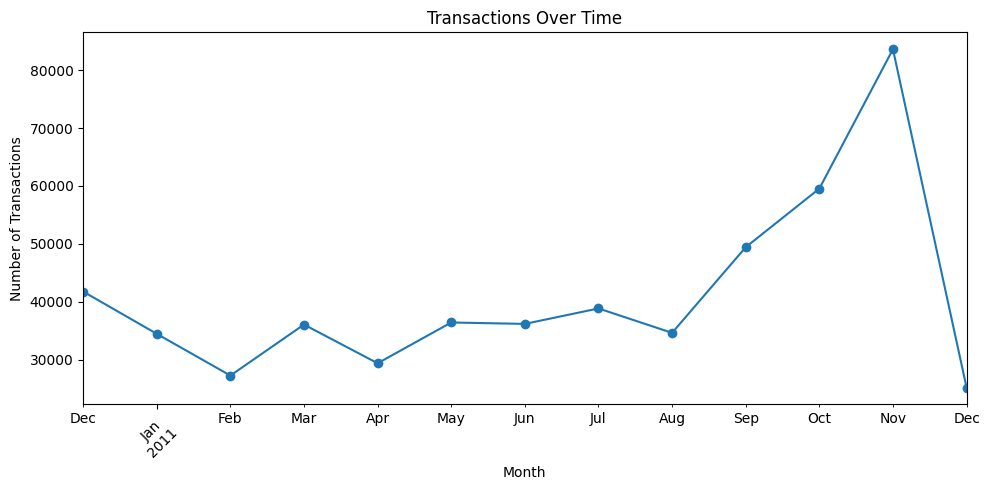

In [10]:
# Set plot style
#plt.style.use('seaborn')

# Histogram for Quantity and UnitPrice
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bin_edges = np.linspace(
    # for this data, after trial and error,
    # we rather define our own explicit bins
    df['Quantity'].quantile(0.01),
    df['Quantity'].quantile(0.99),
    26  # 25 bins needs 26 edges
)
sns.histplot(df['Quantity'], bins=bin_edges, kde=True, stat='probability', edgecolor='black', linewidth=1, alpha=0.7)
plt.title('Distribution of Quantity (Sales Only)')
plt.xlabel('Quantity')
plt.xlim(df['Quantity'].quantile(0.025), df['Quantity'].quantile(0.975))  # Limit outliers

plt.subplot(1, 2, 2)
bin_edges = np.linspace(
    0,
    df['UnitPrice'].quantile(0.99),
    26  # 25 bins needs 26 edges
)
sns.histplot(df['UnitPrice'], bins=bin_edges, kde=True, stat='probability', edgecolor='black', linewidth=1, alpha=0.7)
plt.title('Distribution of UnitPrice (Sales Only)')
plt.xlabel('UnitPrice (£)')
plt.xlim(0, df['UnitPrice'].quantile(0.99))  # Limit outliers

plt.tight_layout()
plt.show()

# Boxplot for Quantity and UnitPrice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(df['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
sns.boxplot(df['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice (£)')
plt.tight_layout()
plt.show()

# Bar chart for top 5 countries
top_countries = df['Country'].value_counts().head(5)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 5 Countries by Transaction Count')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

# Time series of transactions
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_transactions = df.groupby('InvoiceMonth').size()
plt.figure(figsize=(10, 5))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

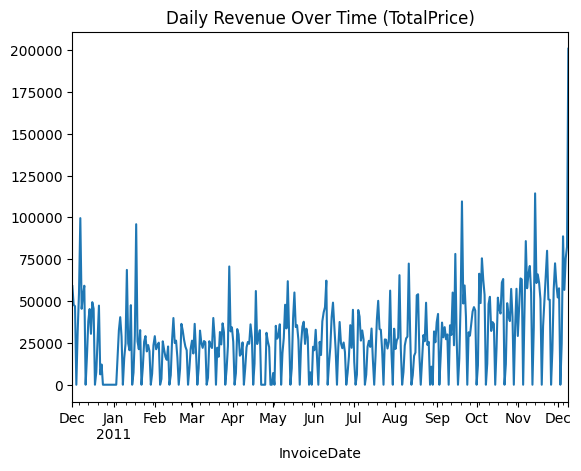

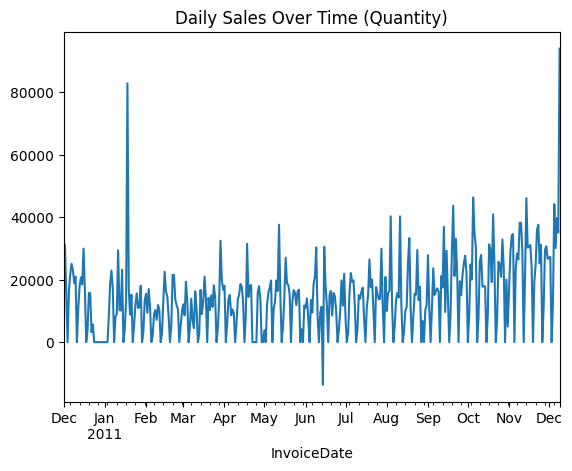

In [11]:
df.set_index('InvoiceDate')['TotalPrice'].resample('D').sum().plot()
plt.title('Daily Revenue Over Time (TotalPrice)')
plt.show()

df.set_index('InvoiceDate')['Quantity'].resample('D').sum().plot()
plt.title('Daily Sales Over Time (Quantity)')
plt.show()

#### Descriptive Statistics for Categorical Features:


Unique Values in Categorical Features:
Country: 38 unique values
StockCode: 4059 unique values
CustomerID: 4340 unique values
Cancellations: 0


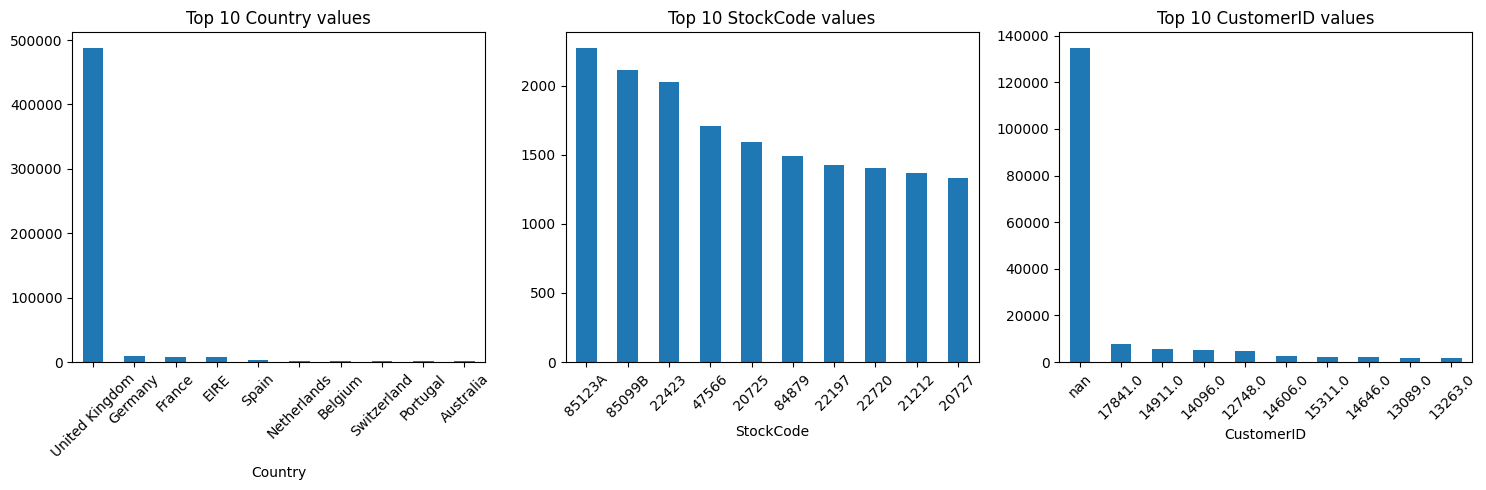

In [12]:
catergorical_cols = ['Country', 'StockCode', 'CustomerID']  # CustomerID might have too many unique values

# Categorical features summary
print("\nUnique Values in Categorical Features:")
for col in catergorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
print(f"Cancellations: {df['IsCancelled'].sum()}")

plt.figure(figsize=(15, 5))
for i, col in enumerate(catergorical_cols, 1):
    plt.subplot(1, len(catergorical_cols), i)
    df[col].value_counts().head(10).plot.bar()  # Top 10 only
    plt.title(f'Top 10 {col} values')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Other Document Sections:

- Model Selection : Nikhil
- Model Analysis : Tamayi
- Conclusion and Recommendations: Tamayi